In [10]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 数据加载

### 创建dataset
- 加载CIFAR-10数据
- 进行数据预处理, (转换为tensor, 并进行标准化)

下面简单说明以下为什么标准化里的参数都是0.5, 这可以保证标准化之后的图像的像素值在-1到1之间. 这是因为: 

For example, the minimum value 0 will be converted to (0-0.5)/0.5=-1, the maximum value of 1 will be converted to (1-0.5)/0.5=1.

### 创建dataloader
- 将dataset传入dataloader, 设置batchsize

In [2]:
# 将数据集合下载到指定目录下,这里的transform表示，数据加载时所需要做的预处理操作
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 加载训练集合(Train)
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                           train=True,
                                           transform=transform,
                                           download=True)

# 加载测试集合(Test)
test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                          train=False,
                                          transform=transform,
                                          download=True)
print(train_dataset) # 训练集
print(test_dataset) # 测试集

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [3]:
# 定义class
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
batch_size = 10
# 根据数据集定义数据加载器
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

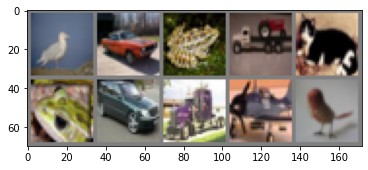

 bird   car  frog truck   cat  frog   car truck plane  bird


In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images, nrow=5))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

## 网络的构建


In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # n*6*14*14
        x = self.pool(F.relu(self.conv2(x))) # n*16*5*5
        x = x.view(-1, 16 * 5 * 5) # n*400
        x = F.relu(self.fc1(x)) # n*120
        x = F.relu(self.fc2(x)) # n*84
        x = self.fc3(x) # n*10
        return x

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [19]:
# 简单测试模型的输出
examples = iter(test_loader)
example_data, _ = examples.next()

net(example_data.to(device)).shape

torch.Size([10, 10])

## 定义损失函数和优化器

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 模型的训练与测试

In [23]:
num_epochs = 10
n_total_steps = len(train_loader)

LossList = [] # 记录每一个epoch的loss
AccuryList = [] # 每一个epoch的accury

for epoch in range(num_epochs):
    # -------
    # 开始训练
    # -------
    net.train() # 切换为训练模型
    totalLoss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) # 图片大小转换
        labels = labels.to(device)

        # 正向传播以及损失的求取
        outputs = net(images)
        loss = criterion(outputs, labels)
        totalLoss = totalLoss + loss.item()

        # 反向传播
        optimizer.zero_grad() # 梯度清空
        loss.backward() # 反向传播
        optimizer.step() # 权重更新

        if (i+1) % 1000 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, n_total_steps, totalLoss/(i+1)))
    
    LossList.append(totalLoss/(i+1))

    # ---------
    # 开始测试
    # ---------
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1) # 预测的结果
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100.0 * correct / total # 在测试集上总的准确率
        AccuryList.append(acc)
        print('Accuracy of the network on the {} test images: {} %'.format(total, acc))

print("模型训练完成")

Epoch [1/10], Step [1000/5000], Loss: 2.2590
Epoch [1/10], Step [2000/5000], Loss: 2.1109
Epoch [1/10], Step [3000/5000], Loss: 1.9928
Epoch [1/10], Step [4000/5000], Loss: 1.9058
Epoch [1/10], Step [5000/5000], Loss: 1.8395
Accuracy of the network on the 10000 test images: 41.0 %
Epoch [2/10], Step [1000/5000], Loss: 1.5120
Epoch [2/10], Step [2000/5000], Loss: 1.4883
Epoch [2/10], Step [3000/5000], Loss: 1.4701
Epoch [2/10], Step [4000/5000], Loss: 1.4529
Epoch [2/10], Step [5000/5000], Loss: 1.4382
Accuracy of the network on the 10000 test images: 52.15 %
Epoch [3/10], Step [1000/5000], Loss: 1.3187
Epoch [3/10], Step [2000/5000], Loss: 1.3127
Epoch [3/10], Step [3000/5000], Loss: 1.3039
Epoch [3/10], Step [4000/5000], Loss: 1.2895
Epoch [3/10], Step [5000/5000], Loss: 1.2808
Accuracy of the network on the 10000 test images: 56.75 %
Epoch [4/10], Step [1000/5000], Loss: 1.1908
Epoch [4/10], Step [2000/5000], Loss: 1.1878
Epoch [4/10], Step [3000/5000], Loss: 1.1892
Epoch [4/10], Ste

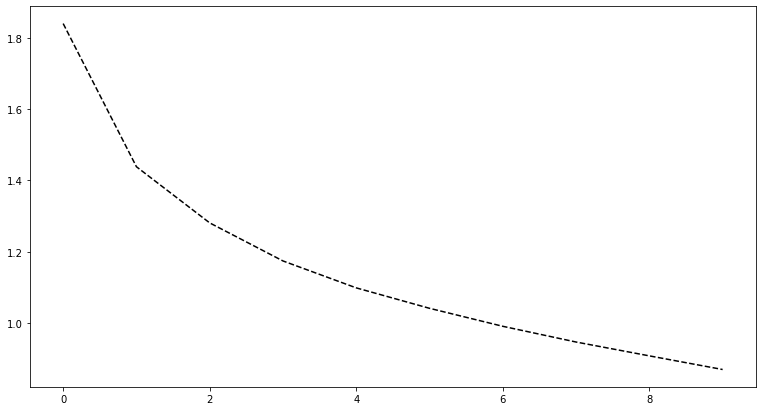

In [24]:
# 绘制loss的变化
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13,7))
axes.plot(LossList, 'k--')

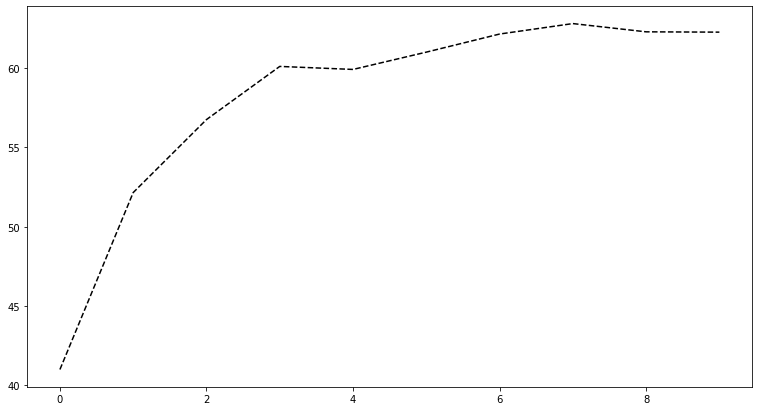

In [25]:
# 绘制loss的变化
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13,7))
axes.plot(AccuryList, 'k--')

## 使用实际例子进行验证

In [28]:
# 测试样例
examples = iter(test_loader)
example_data, example_targets = examples.next()


# 结果的预测
images = example_data.to(device)
labels = example_targets.to(device)

# 正向传播以及损失的求取
outputs = net(images)
# 将 Tensor 类型的变量 example_targets 转为 numpy 类型的，方便展示
print("上面9张图片的真实结果：", example_targets[0:9].cpu().detach().numpy())
# 将得到预测结果
# 由于预测结果是 N×10 的矩阵，因此利用 np.argmax 函数取每行最大的那个值，最为预测值
print("上面9张图片的预测结果：", np.argmax(outputs[0:9].cpu().detach().numpy(), axis=1))

上面9张图片的真实结果： [3 8 8 0 6 6 1 6 3]
上面9张图片的预测结果： [6 8 1 8 6 6 1 4 2]


## 每一类的准确率

- 每一类的准确率

In [29]:
class_correct = list(0. for i in range(10)) # 每一类预测正确的个数
class_total = list(0. for i in range(10)) # 每一类的总个数

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10): # 一个batch中的个数
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 81 %
Accuracy of  bird : 43 %
Accuracy of   cat : 25 %
Accuracy of  deer : 60 %
Accuracy of   dog : 66 %
Accuracy of  frog : 73 %
Accuracy of horse : 67 %
Accuracy of  ship : 73 %
Accuracy of truck : 65 %


## 使用更深的网络-VGG

In [37]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 2
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 4
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 5
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 6
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 7
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 8
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 9
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 10
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 11
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 12
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 13
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AvgPool2d(kernel_size=1, stride=1),
        )
        self.classifier = nn.Sequential(
            # 14
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            # 15
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            # 16
            nn.Linear(4096, num_classes),
        )
        #self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


# 定义当前设备是否支持 GPU
net = VGG16().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [38]:
num_epochs = 10
n_total_steps = len(train_loader)

LossList = [] # 记录每一个epoch的loss
AccuryList = [] # 每一个epoch的accury

for epoch in range(num_epochs):
    # -------
    # 开始训练
    # -------
    net.train() # 切换为训练模型
    totalLoss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) # 图片大小转换
        labels = labels.to(device)

        # 正向传播以及损失的求取
        outputs = net(images)
        loss = criterion(outputs, labels)
        totalLoss = totalLoss + loss.item()

        # 反向传播
        optimizer.zero_grad() # 梯度清空
        loss.backward() # 反向传播
        optimizer.step() # 权重更新

        if (i+1) % 2500 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, n_total_steps, totalLoss/(i+1)))
    
    LossList.append(totalLoss/(i+1))

    # ---------
    # 开始测试
    # ---------
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1) # 预测的结果
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100.0 * correct / total # 在测试集上总的准确率
        AccuryList.append(acc)
        print('Accuracy of the network on the {} test images: {} %'.format(total, acc))

print("模型训练完成")

Epoch [1/10], Step [2500/5000], Loss: 1.6148
Epoch [1/10], Step [5000/5000], Loss: 1.3861
Accuracy of the network on the 10000 test images: 63.32 %
Epoch [2/10], Step [2500/5000], Loss: 0.9311
Epoch [2/10], Step [5000/5000], Loss: 0.8755
Accuracy of the network on the 10000 test images: 74.7 %
Epoch [3/10], Step [2500/5000], Loss: 0.6964
Epoch [3/10], Step [5000/5000], Loss: 0.6761
Accuracy of the network on the 10000 test images: 78.86 %
Epoch [4/10], Step [2500/5000], Loss: 0.5386
Epoch [4/10], Step [5000/5000], Loss: 0.5328
Accuracy of the network on the 10000 test images: 81.19 %
Epoch [5/10], Step [2500/5000], Loss: 0.4332
Epoch [5/10], Step [5000/5000], Loss: 0.4394
Accuracy of the network on the 10000 test images: 79.04 %
Epoch [6/10], Step [2500/5000], Loss: 0.3462
Epoch [6/10], Step [5000/5000], Loss: 0.3551
Accuracy of the network on the 10000 test images: 83.0 %
Epoch [7/10], Step [2500/5000], Loss: 0.2812
Epoch [7/10], Step [5000/5000], Loss: 0.2904
Accuracy of the network 

In [39]:
class_correct = list(0. for i in range(10)) # 每一类预测正确的个数
class_total = list(0. for i in range(10)) # 每一类的总个数

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10): # 一个batch中的个数
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 83 %
Accuracy of   car : 94 %
Accuracy of  bird : 79 %
Accuracy of   cat : 74 %
Accuracy of  deer : 83 %
Accuracy of   dog : 72 %
Accuracy of  frog : 91 %
Accuracy of horse : 88 %
Accuracy of  ship : 91 %
Accuracy of truck : 90 %
